# Analysis functions

In [1]:
import numpy as np
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from scipy.optimize import leastsq, curve_fit
from scipy.integrate import odeint


def printDict(dic):
  string = ""
  for i,c in enumerate(dic.items()):
    if isinstance(c[1], str):
      if i == 0:
        string += ('{'+f"'{c[0]}' : '{c[1]}',\n")
      elif i == len(dic.items()) - 1:
        string += (f"'{c[0]}' : '{c[1]}'" + '}')
      else:
        string += (f"'{c[0]}' : '{c[1]}',\n")
    else:
      if i == 0:
        string += ('{'+f"'{c[0]}' : {c[1]},\n")
      elif i == len(dic.items()) - 1:
        string += (f"'{c[0]}' : {c[1]}" + '}')
      else:
        string += (f"'{c[0]}' : {c[1]},\n")


def trange(range_description):
    start, end = range_description.split(':')
    start_col, start_row = start[0], int(start[1:])
    end_col, end_row = end[0], int(end[1:])

    columns = [chr(col) for col in range(ord(start_col), ord(end_col) + 1)]
    rows = range(start_row, end_row + 1)

    cell_list = [f'{col}{row}' for row in rows for col in columns]
    return cell_list




def calibrate_data(concentrations, endpoints, err, text = None, verbose = True):

    def func(x, a, b):
        return a * x + b

    popt, pcov = curve_fit(func, concentrations, endpoints)
    print('Best fit: Fluorescence = ' + str(round(popt[0],2)) + " * [F2t(nM)] + " + str(round(popt[1],2)))

    sim = [x for x in range(0,int(concentrations[-1])+2,1)]
    model = [func(x,popt[0],popt[1]) for x in range(0,int(concentrations[-1])+2,1)]






    #plt.savefig('figures/Experimental.png', dpi = 600)
    if verbose:
      plt.scatter(concentrations, endpoints)

      if text == None:
        plt.xlabel('Trigger concentration (nM)')
        plt.ylabel('Fluorescence (rfu)')
        plt.title('Fluorescence vs input concentration')
      else:
        plt.xlabel(text[0])
        plt.ylabel(text[1])
        plt.title(text[2])
      plt.plot(sim, model, color='orange')
      plt.errorbar(concentrations, endpoints, yerr=err, fmt="o")
      #plt.savefig('figures/ExperimentalWModel.png', dpi = 600)

      plt.show()

    return [popt[1], popt[0]]


def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std

def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()





def threeModel(y, t, kf1 ,kf2 ,kr1,kr2, kf, krep, scale, dG):
    P, Y1,F1t, F0t, X1, F2, F1, F0, W0, W1, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dX1dt = kr*F0t*W0 - kf*X1*F0
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0tdt = kf*X1*F0 - kr*F0t*W0 - kf1*F0t*F1 + kr1*F1t*W1
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW0dt =  kf*X1*F0 - kr*W0*F0t
    dW1dt = kf1*F0t*F1 - kr1*W1*F1t
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt, dF0tdt, dX1dt, dF2dt, dF1dt, dF0dt, dW0dt, dW1dt, dW2dt)

def twoModel(y, t,kf2, kr2, kf, krep, scale, dG):
    P, Y1,F1t, F0t, F2, F1,  W1, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW1dt = kf1*F0t*F1 - kr1*W1*F1t
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt, dF0tdt, dF2dt, dF1dt, dW1dt, dW2dt)

def oneModel(y, t, kf, krep, scale, dG):
    P, Y1,F1t,F2, W2 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    kr = kf/(math.exp(-dG/RT))
    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt, dF1tdt,  dF2dt, dW2dt)

def reporterModel(y, t, kf, scale, dG):
    P, Y1 = y
    # CRN:
    # X1 <krev-kf> Y1
    # (X1 + F0 <krev-kf> F0t + W0)
    # (F0t + F1 <krev-kf> F1t + W1)
    # (F1t + F2 <krev-kf> Y1 + W2)
    # Y1 + R1 -kr> P


    #Rate of reporting
    R1 = scale - P
    dPdt = krep*(R1)*(Y1)

    #Rate of change of input and output
    dY1dt = kf2*F1t*F2 - kr2*Y1*W2 - dPdt

    #Rate of change of gate concentrations
    dF1tdt = kf1*F0t*F1 - kr1*F1t*W1 - kf2*F1t*F2 + kr2*Y1*W2
    dF0dt = -kf*X1*F0 + kr*F0t*W0
    dF1dt = -kf1*F0t*F1 + kr1*F1t*W1
    dF2dt = -kf2*F1t*F2 + kr2*Y1*W2

    #Rate of change of waste concentrations
    dW2dt = kf2*F1t*F2 - kr2*W2*Y1

    return (dPdt, dY1dt)

def modelCascade(kf, tArray, fixed_params, dG, depth):
    t = tArray
    scale = 1e-9*scale

    if depth == 3:
      # Unpack the input parameters
      y0, krep, kf1, kf2, kr1, kr2, scale = fixed_params['y0'], fixed_params['krep'],fixed_params['kf1'], fixed_params['kf2'], fixed_params['kr1'],fixed_params['kr2'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf1, kf2, kr1,kr2,kf, krep, scale, dG[0]), rtol = 1e-12, atol = 1e-12)]
    elif depth == 2:
      # Unpack the input parameters
      y0, krep, kf2, kr2, scale = fixed_params['y0'], fixed_params['krep'],fixed_params['kf2'], fixed_params['kr2'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf1, kf2, kr1,kr2,kf, krep, scale, dG[1]), rtol = 1e-12, atol = 1e-12)]
    elif depth == 1:
      # Unpack the input parameters
      y0, krep, scale = fixed_params['y0'], fixed_params['krep'],  fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalot model based on initial conditions and fit
      y1 = [i[0] for i in odeint(translatorModel, y0, t, args=(kf, krep, scale, dG[2]), rtol = 1e-12, atol = 1e-12)]
    else:
      # Unpack the input parameters
      y0, krep, scale = fixed_params['y0'],   fixed_params['scale']
      y0 = [i*1e-9 for i in y0]
      #Solve transalor model based on initial conditions and fit
      y1 = [i[0] for i in odeint(reporterModel, y0, t, args=(kf, krep, scale), rtol = 1e-12, atol = 1e-12)]

    if kf < 0 :
      y1 = [np.inf for _ in range(len(y1))]

    return y1



def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[-1]+(t[-1]-t[-2]),t[-1]-t[-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[0]])
        model_y = modelCascade(kf, tfull, fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)

def fit_modelCascade(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    out, sucess = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return out


import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

class Result:
  def __init__(self, add, range, conditions, start, offset, calibration = None):
    self.rawdata = getRange(add, range)
    self.conditions = conditions
    self.x = [timeToSec(i) for i in list(self.rawdata['Time'].values)]
    self.start = timeToSec(start)
    self.offset = offset
    self.x_trunc = None

    if not(calibration == None):
      self.calibration = calibration


  def inConditions(self, name):
    name_strings = list(self.conditions.keys())
    include = []
    for i,nm in enumerate(name_strings):
      if name in nm:
        include.append(i)
    return [name_strings[i] for i in range(len(name_strings)) if i in include]

  def getSpeciesConcentration(self, condition, species):
    choices = re.split(',', condition)
    indexArr = [i for i in range(len(choices)) if species in choices[i]]
    assert(len(indexArr)==1)
    index = indexArr[0]
    concentration = float(re.split(' ', choices[index])[1])

    return concentration


  def calibrateReporter(self, trigger, text = None, verbose = True):
    levels = self.getCalibrationConditions()
    dfArray = []
    for l in levels:
      dfArray.append(getEndpoint(l, self.x, self.rawdata, self.conditions))

    merged_df = pd.concat(dfArray, ignore_index=True)

    conc = [self.getSpeciesConcentration(l, trigger) for l in levels]

    y = merged_df['Row Average'].values[0:-1]
    err = merged_df['Row Std'].values[0:-1]
    self.calibration = calibrate_data(conc[0:-1], y, err, text, verbose)



  def getNormalizedAverages(self, levels):
    outCurves = []
    dev = []
    for l in levels:
      outCurves.append(getAverageCurve(self.start, self.offset, l, self.x, self.rawdata, self.conditions, self.calibration)[1])
      dev.append(getAverageCurve(self.start, self.offset, l, self.x, self.rawdata, self.conditions, self.calibration)[2])

    print
    return outCurves,dev


  def getCalibrationConditions(self):
    name_strings = list(self.conditions.keys())
    return [name_strings[i] for i in range(len(name_strings)) if len(re.split(',',name_strings[i])) == 2]



  def viewData(self):
      display(self.rawdata)


  def exploreData(self):
      df = self.rawdata

      # Extract time and temperature columns
      time_col = 'Time'
      temp_col = 'T° ATTO565_120:563,592'

      # Extract well-specific fluorescence columns
      fluorescence_cols = [col for col in df.columns if col not in [time_col, temp_col]]

      # Melt the DataFrame to long format for Plotly Express
      melted_df = pd.melt(df, id_vars=[time_col, temp_col], value_vars=fluorescence_cols, var_name='Well', value_name='RFU')

      # Ensure 'RFU' is treated as numeric
      melted_df['RFU'] = pd.to_numeric(melted_df['RFU'], errors='coerce')

      # Create a figure using Plotly graph_objects
      fig = go.Figure()

      # Add traces for each well
      for well in melted_df['Well'].unique():
          well_data = melted_df[melted_df['Well'] == well]
          fig.add_trace(go.Scatter(x=well_data[time_col], y=well_data['RFU'], mode='lines', name=well))

      # Customize the layout
      fig.update_layout(title='Fluorescence Data Visualization',
                        xaxis_title='Time',
                        yaxis_title='RFU',
                        legend_title='Well',
                        template='plotly_dark')  # You can choose a different template if you prefer
      return fig




# Importing data

## Invader c/isoC

In [2]:
data = pd.read_csv("TUM_NN_Mismatches_RepIsoG.csv")
data

,Unnamed: 0,time,Inv C: Rep G,Inv C : Rep T,Inv C : Rep C,Inv C : Rep A,Inv isoC : Rep G,Inv isoC: Rep T,Inv isoC: Rep C,Inv isoC: Rep A,Inv isoC : Rep isoG
0,0,0,1.315271,0.197044,0.429392,0.191297,0.157635,0.463875,0.218391,0.151067,3.883279
1,1,60,1.808703,0.409688,0.166667,0.203612,0.305419,0.401478,0.651067,0.362890,5.669790
2,2,120,2.389984,0.238095,0.473727,0.239737,0.430213,0.362069,0.165846,0.103448,6.869246
3,3,180,3.023810,0.236453,0.258621,0.403941,0.169130,0.509852,0.114122,0.200328,7.806100
4,4,240,3.263547,0.347291,0.454844,0.142036,0.325123,0.642036,0.398194,0.383415,9.173865
...,...,...,...,...,...,...,...,...,...,...,...
995,995,59790,19.773399,1.854680,1.538588,1.883415,7.433498,1.753695,2.332512,6.379310,20.297481
996,996,59850,19.656814,1.981117,1.599343,1.516420,7.587028,1.843186,2.499179,6.625616,19.917265
997,997,59910,19.931856,2.137931,1.843186,1.737274,7.800493,1.696223,2.420361,6.877668,19.839194
998,998,59970,19.889163,1.637110,1.600164,2.014778,7.564860,1.713465,2.504105,6.649425,19.924362


## Invader G/isoG

In [3]:
data2 = pd.read_csv("TUM_NN_Mismatches_InvIsoC.csv")
data2

,Unnamed: 0,time,Inv C: Rep G,Inv T: Rep G,Inv G: Rep G,Inv A: Rep G,Inv C: Rep isoG,Inv T: Rep isoG,Inv G: Rep isoG,Inv A: Rep isoG
0,0,0,0.606594,0.176784,0.211135,0.143270,0.084622,0.211973,0.395459,0.205270
1,1,90,1.546647,0.214486,0.253027,0.186000,0.177621,0.110594,0.248000,-0.044405
2,2,180,2.148213,0.040216,0.027649,0.108081,0.468351,0.313351,0.359432,0.080432
3,3,270,2.450672,0.240459,0.107243,0.385405,0.237108,0.324243,0.217838,0.157513
4,4,360,3.451887,0.250513,0.243810,0.185162,0.509405,0.208621,0.245486,-0.038540
...,...,...,...,...,...,...,...,...,...,...
995,995,89550,20.042730,3.844833,2.103808,1.054836,10.989904,8.545934,8.153827,0.862134
996,996,89640,19.784676,3.105023,2.203511,1.131917,10.811445,8.221692,8.328935,1.291106
997,997,89730,19.908676,3.486239,2.216916,1.344728,11.303255,8.331448,8.519124,1.040593
998,998,89820,20.190189,3.671400,2.080349,1.296133,10.913661,8.292908,8.218340,1.022161


# Analysis

In [5]:
df2_data = {"condition" : [],
            "completion" : []}

time_ind = min([i for i,t in enumerate(data['time']) if float(t) >= 60*60*6])

for cond in list(data.columns[1:]):
  df2_data["condition"] += [cond]
  df2_data['completion'] += [float(data[cond].values[time_ind])/20]

time_ind2 = min([i for i,t in enumerate(data2['time']) if float(t) >= 60*60*6])

for cond in list(data2.columns[1:]):
  if cond not in df2_data['condition']:
    df2_data["condition"] += [cond]
    df2_data['completion'] += [float(data2[cond].values[time_ind2])/20]

df2 = pd.DataFrame(df2_data)
df2.sort_values(by=['completion'], ascending=True, inplace=True, ignore_index=True)
df2




,condition,completion
0,Inv A: Rep isoG,0.010389
1,Inv A: Rep G,0.026518
2,Inv C : Rep A,0.037438
3,Inv G: Rep G,0.046919
4,Inv isoC: Rep T,0.058210
5,Inv C : Rep C,0.060920
6,Inv C : Rep T,0.061741
7,Inv T: Rep G,0.067488
8,Inv isoC: Rep C,0.075246
9,Inv isoC: Rep A,0.149015


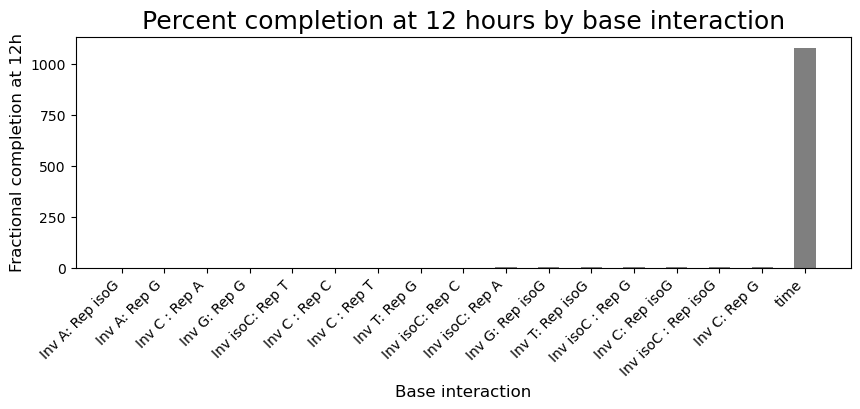

In [ ]:
import matplotlib

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color = color_scheme[-3]

plt.figure(figsize=(10,3))
#plt.scatter(df2['condition'], df2['completion'])
labels = df2['condition']
x = np.arange(len(labels))
dx = 1
bar_width = 0.5
y = df2['completion']
plt.bar(x + dx, y, width=bar_width, color=color)

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)


plt.xticks(np.arange(1, len(labels)+1), labels)
plt.tick_params(axis='x')
plt.xticks(rotation=45, ha='right')
plt.title('Percent completion at 12 hours by base interaction', fontsize=18)
plt.xlabel('Base interaction', fontsize=12)
plt.ylabel('Fractional completion at 12h', fontsize=12)
#plt.savefig('NNMismatchesPlot.svg')


